# Imports

In [1]:
!pip install transformers
!pip install sentence_transformers
!pip install datasets
!pip install sentencepiece
!pip install scikit-learn-extra
!pip install wikipedia
!pip install eli5
!pip install lime


     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 901kB 17.6MB/s 
     |████████████████████████████████| 3.3MB 23.1MB/s 
     |████████████████████████████████| 81kB 2.1MB/s 
     |████████████████████████████████| 1.2MB 10.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=20e74cd131e5a6f9a9f1c6f2364c5c781e8e1d014ade5c7ff944a0553ce8d9ff
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers
     |████████████████████████████████| 235kB 2.9MB/s 
     |████████████████████████████████| 245kB 11.9MB/s 
     |████████████████████████████████| 112kB 12.2MB/s 
     |████████████████████████████████| 1.7MB 2.9MB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successf

In [2]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import argparse
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import os
import random
import shutil
import lime
import lime.lime_tabular
import wikipedia
import time
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from PIL import Image
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import sys
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.gaussian_process.kernels import RBF
import torch
from sklearn.metrics.pairwise import rbf_kernel

from scipy.stats import multivariate_normal
import  scipy.stats as st
from matplotlib import cm
import torch.optim as optim
from __future__ import print_function
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW, AutoModel
import nltk
from torch.utils.data import DataLoader
import pickle
import spacy
from gensim import corpora, models, similarities
import gensim
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from sklearn.metrics.pairwise import rbf_kernel
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
import pickle
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import matplotlib
from sklearn.metrics.pairwise import rbf_kernel
import copy
import eli5
from eli5.lime import TextExplainer
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

cuda:0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# HotpotQA


In [4]:
from datasets import load_dataset
DISTRACTORS_PARS_LEN = 0
dataset = load_dataset("hotpot_qa", 'distractor')
train_dataset = dataset['train']
validation_dataset = dataset['validation']

Dataset hotpot_qa downloaded and prepared to /root/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/133b9501f892e5193babbad937bee3b4899deb4691ef4d791e6ac0111c875bb5. Subsequent calls will reuse this data.


In [5]:
def get_token_lenght(context, question):
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    return len(inputs['input_ids'][0])

def remove_distractors(example, n_distractors = 0):
    all_pars = example['context']['title']
    gold_pars = list(set(example['supporting_facts']['title']))
    distractor_pars = list(set(all_pars) - set(gold_pars))
    # get indices to keep from disractors
    if len(distractor_pars) == 0 or n_distractors == 0:
        distract_indices = []
    else:
        distract_indices = random.sample(range(len(distractor_pars)), n_distractors)
    distractor_pars = [distractor_pars[idx] for idx in distract_indices]
    keep_pars = gold_pars + distractor_pars
    keep_pars_indices = [all_pars.index(keep_par) for keep_par in keep_pars]
    example['context']['title'] = [example['context']['title'][idx] for idx in keep_pars_indices]
    example['context']['sentences'] = [example['context']['sentences'][idx] for idx in keep_pars_indices]
    
    sentences_par = ["".join(example['context']['sentences'][idx]) for idx in range(len(example['context']['sentences']))]
    example['intros'] = " ".join([example['context']['sentences'][idx][0] for idx in range(len(example['context']['sentences']))])
    example['passage'] = " #$ ".join(sentences_par)
    return example



In [6]:
train_dataset = train_dataset.map(remove_distractors)
validation_dataset = validation_dataset.map(remove_distractors)

In [7]:
# Free form vs yes/no
all_indices = set(list(range(len(validation_dataset))))
yes_no_indices = set([i  for i in range(len(validation_dataset)) if validation_dataset[i]['answer'] in ["yes","no"] ])
free_indices_val = all_indices - yes_no_indices
all_indices = set(list(range(len(train_dataset))))
yes_no_indices_train = set([i  for i in range(len(train_dataset)) if (train_dataset[i]['answer'] in ["yes","no"]) or (train_dataset[i]['level'] in ['easy','medium']) ])
free_indices_train = all_indices - yes_no_indices_train
print(len(free_indices_val))
print(len(free_indices_train))


6947
14631


In [8]:
hard_dataset = [train_dataset[i] for i in free_indices_train ]
hard_dataset += [validation_dataset[i] for i in free_indices_val]
dataset_indices =  set(list(range(len(hard_dataset))))
VAL_START = len([train_dataset[i] for i in free_indices_train ])
len(hard_dataset)

21578

## Utils

In [9]:

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)



def evaluate_truth_pred(truths, preds):
    '''
    truths, preds: matched arrays of ground truth answers and predictions
    '''
    f1 = exact_match = total = 0
    for i in range(len(truths)):
        total += 1
        if truths[i] in ['yes', "no"]:
            continue
        ground_truths = [truths[i]]
        prediction = preds[i]
        exact_match += metric_max_over_ground_truths(
            exact_match_score, prediction, ground_truths)
        f1 += metric_max_over_ground_truths(
            f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / (total+ 0.00000000001)
    f1 = 100.0 * f1 / (total+ 0.00000000001)

    return {'exact_match': exact_match, 'f1': f1}


def get_answer( model, tokenizer, context, question):
    # 1. TOKENIZE THE INPUT
    # note: if you don't include return_tensors='pt' you'll get a list of lists which is easier for
    # exploration but you cannot feed that into a model.
    inputs = tokenizer.encode_plus(question, context, return_tensors="pt")
    inputs = inputs.to(device)
    # 2. OBTAIN MODEL SCORES
    # the AutoModelForQuestionAnswering class includes a span predictor on top of the model.
    # the model returns answer start and end scores for each word in the text
    answer_start_scores, answer_end_scores = model(**inputs, return_dict=False)
    answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
    # 3. GET THE ANSWER SPAN
    # once we have the most likely start and end tokens, we grab all the tokens between them
    # and convert tokens back to words!
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))
    return answer
# https://huggingface.co/transformers/migration.html
def model_evaluation(model, tokenizer, questions, contexts, answers, to_print = False):
    preds = []
    my_list = list(range(len(questions)))
    with tqdm(total=len(my_list)) as pbar:
        for ex in range(len(questions)):
            answer = get_answer(model, tokenizer, contexts[ex],questions[ex])
            preds.append(answer)
            if ex % 100 == 0 and to_print:
                print("context " +contexts[ex] )
                print("quest " +questions[ex] )
                print("truth " +answers[ex]['text'] )
                print("pred " + answer)
            pbar.update(1)
    truths = [answers[i]['text'] for i in range(len(answers))]
    scores = evaluate_truth_pred(truths, preds)
    print(scores)
    return scores


def kernel_similarity(x, y):
        kernel_dist = rbf_kernel(x.reshape(1, -1),y.reshape(1, -1))
        return kernel_dist[0][0]


# FakeAI model

In [10]:
class FakeAI:
    r"""
    FakeAI that is incorrect in random clusters in the input space
    
    Args:
        train_passages: list of embedded passages
        train_questions: list of embedded questions
        n_clus_p: number of centroids in kmeans for passages
        n_clus_q: number of centroids in kmeans for questions
        clust_err_p: clusters where AI makes error on passages
        clust_err_q: clusters where AI makes error on questions
    """
    def __init__(self, train_passages, train_questions, n_clus_p, n_clus_q, beta_params = (1,1), kmeans = None, err_p = None):
 
        self.train_passages = train_passages
        self.train_questions = train_questions
        self.n_clus_p = n_clus_p
        self.n_clus_q = n_clus_q
        if err_p == None:
            self.clust_err_p = np.random.beta(beta_params[0],beta_params[1],self.n_clus_p)
            '''
            for i in range(len(self.clust_err_p)):
                if self.clust_err_p[i] <= 0.333333:
                    self.clust_err_p[i] = 0.0
                elif self.clust_err_p[i]>=0.6666666:
                    self.clust_err_p[i] = 1.0
                else:
                    self.clust_err_p[i] = 0.5
            '''
        else:
            self.clust_err_p = err_p
        self.clust_err_q = np.random.beta(0.2,0.8,self.n_clus_p)#np.random.rand(self.n_clus_q)#/2 + 0.5
        if kmeans == None:
            self.build_kmeans()
        else:
            self.kmeans_pass = kmeans
            self.kmeans_quest = kmeans

        
    def build_kmeans(self):
        # Builds kmeans for passages and questions
        self.kmeans_quest = KMeans(n_clusters=self.n_clus_q, max_iter = 10000).fit(self.train_questions)
        self.kmeans_pass = KMeans(n_clusters=self.n_clus_p, max_iter = 100000).fit(self.train_passages)

    def predict_right_wrong(self, passages, questions):
        '''
        Args:
            passages: list of embedded passages
            questions: list of embedded questions (same size as passages)
        Returns:
            preds: binary array indicating if AI is right (1) or wrong (0)
        '''
        clusts_p = self.kmeans_pass.predict(passages)
        clusts_q = self.kmeans_quest.predict(questions)
        preds = []
        for i in range(len(clusts_p)):
            coin = random.random() # random number between [0,1]
            if coin >= self.clust_err_p[clusts_p[i]]:
                preds.append(0)
            else:
                preds.append(1)
        return preds

    
    def predict_raw_probas(self, passages, questions):
        '''
        Args:
            passages: list of embedded passages
            questions: list of embedded questions (same size as passages)
        Returns:
            preds: binary array indicating if AI is right (1) or wrong (0)
        '''
        clusts_p = self.kmeans_pass.predict(passages)
        clusts_q = self.kmeans_quest.predict(questions)
        preds = []
        for i in range(len(clusts_p)):
            preds.append(self.clust_err_p[clusts_p[i]])
        return preds
    
    def prior_rejector(self, passages, questions, epsilon_reject):
        '''
        rejector defined as : 1{prob_of_correct <= epsilon_reject}
        '''
        clusts_p = self.kmeans_pass.predict(passages)
        clusts_q = self.kmeans_quest.predict(questions)
        preds = []
        for i in range(len(clusts_p)):
            coin = random.random() # random number between [0,1]
            if  self.clust_err_p[clusts_p[i]] <= epsilon_reject:
                preds.append(1)
            else:
                preds.append(0)
        return preds

    def predict_proba(self, raw_passages):
        embed_ps = model.encode(raw_passages)
        embed_ps = [embed_ps[i] for i in range(len(embed_ps))]
        clusts_p = self.kmeans_pass.predict(embed_ps)
        preds = []
        for i in range(len(clusts_p)):
            coin = random.random() # random number between [0,1]
            if coin >= self.clust_err_p[clusts_p[i]]:
                preds.append([0.0,1.0])
            else:
                preds.append([1.0,0.0])
        return np.asarray(preds)

    def predict_proba_encoded(self, passages):
        clusts_p = self.kmeans_pass.predict(np.array(passages, dtype=np.float32))
        preds = []
        for i in range(len(clusts_p)):
            coin = random.random() # random number between [0,1]
            if coin >= self.clust_err_p[clusts_p[i]]:
                preds.append([0.0,1.0])
            else:
                preds.append([1.0,0.0])
        return np.asarray(preds)


def is_a_stopword(feature, weight):
    split_words = feature.split(' ')
    for word in split_words:
        if word in stopwords:
            return False
    return True

def get_highlighted_p(ai_model, paragraph):
    '''
    from https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#lime-tutorial
    '''
    
    te = TextExplainer(random_state=42)
    te.fit(paragraph, ai_model.predict_proba)
    show_pred = te.show_prediction(target_names=['correct','false'], top=(8,0), feature_filter = is_a_stopword)
    correct = False
    if show_pred.data.find("y=correct") != -1:
        correct = True
    b = show_pred.data.split('<p style="margin-bottom: 2.5em; margin-top:-0.5em;">')
    to_show = '<p style="margin-bottom: 2.5em; margin-top:-0.5em;">' +b[-1]
    if not correct:
        to_show = to_show.replace("hsl(120,","hsl(0,")
    return to_show

In [11]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-distilroberta-base-v1') #distilbert-base-nli-stsb-mean-tokens
# https://www.sbert.net/docs/pretrained_models.html

# Teaching Prelims



## Human classes and utilities

In [12]:
class HumanLearner:
    def __init__(self, kernel):
        '''
        kernel: function that takes two inputs and returns a similarity
        prior rejector: returns rejector
        '''
        self.teaching_set = []
        self.kernel = kernel
    def predict(self, xs, prior_rejector_preds, to_print = False):
        '''
        xs: expected array of inputs
        '''
        preds = []
        idx = 0
        used_posterior = 0 
        if to_print:
            print("-- Human making reject predictions --")
            with tqdm(total=len(xs)) as pbar:
                for x in xs:
                    ball_at_x = []
                    similarities = rbf_kernel(x.reshape(1,-1), np.asarray([self.teaching_set[kk][0] for kk in range(len(self.teaching_set))]))[0]
                    for i in range(len(self.teaching_set)):
                        similarity = similarities[i]
                        if similarity >=  self.teaching_set[i][2]:
                            ball_at_x.append(self.teaching_set[i])
                    if len(ball_at_x) == 0: 
                        # use prior rejector
                        preds.append(prior_rejector_preds[idx])
                    else:
                        used_posterior += 1
                        ball_similarities = rbf_kernel(x.reshape(1,-1), np.asarray([ball_at_x[kk][0] for kk in range(len(ball_at_x))]))[0]
                        normalization = np.sum([ball_similarities[i] for i in range(len(ball_at_x))])
                        score_one = np.sum([ball_similarities[i]*ball_at_x[i][1] for i in range(len(ball_at_x))])
                        pred = score_one / normalization
                        if pred >= 0.5:
                            preds.append(1)
                        else:
                            preds.append(0)
                    idx += 1
                    pbar.update(1)
        else:
            for x in xs:
                ball_at_x = []
                similarities = rbf_kernel(x.reshape(1,-1), np.asarray([self.teaching_set[kk][0] for kk in range(len(self.teaching_set))]))[0]
                for i in range(len(self.teaching_set)):
                    similarity = similarities[i]
                    if similarity >=  self.teaching_set[i][2]:
                        ball_at_x.append(self.teaching_set[i])
                if len(ball_at_x) == 0: 
                    # use prior rejector
                    preds.append(prior_rejector_preds[idx])
                else:
                    used_posterior += 1
                    ball_similarities = rbf_kernel(x.reshape(1,-1), np.asarray([ball_at_x[kk][0] for kk in range(len(ball_at_x))]))[0]
                    normalization = np.sum([ball_similarities[i] for i in range(len(ball_at_x))])
                    score_one = np.sum([ball_similarities[i]*ball_at_x[i][1] for i in range(len(ball_at_x))])
                    pred = score_one / normalization
                    if pred >= 0.5:
                        preds.append(1)
                    else:
                        preds.append(0)
                idx += 1
        if to_print:
            print(f'Used posterior {used_posterior/len(xs)*100:.2f}')
        return preds

    def add_to_teaching(self, teaching_example):
        '''
        teaching_example: (x, label, gamma)
        '''
        self.teaching_set.append(teaching_example)

    def remove_last_teaching_item(self):
        self.teaching_set = self.teaching_set[:-1]

In [13]:
def compute_predictions_humanai(hum_preds, hum_rejector, ai_preds, data_x):
    '''
    hum_preds: array of human predictions
    ai_preds: array of AI predictions
    hum_rejector: HumanLearner
    data_x: array of inputs

    Returns array of final predictions and deferalls
    '''
    predictions = []
    with torch.no_grad():
        reject_decisions = hum_rejector(data_x)
        for i in range(len(data_x)):
            if reject_decisions[i] == 1:
                # defer
                predictions.append(ai_preds[i])
            else:
                predictions.append(hum_preds[i])
    return predictions, reject_decisions

def get_metrics(preds, truths):
    # custom for each use case
    return evaluate_truth_pred(truths, preds)

def compute_metrics(human_preds, ai_preds, reject_decisions, truths, to_print = False):
    coverage = 1 - np.sum(reject_decisions)/len(reject_decisions)
    humanai_preds = []
    human_preds_sys = []
    truths_human = []
    ai_preds_sys = []
    truths_ai = []
    for i in range(len(reject_decisions)):
        if reject_decisions[i] == 1:
            humanai_preds.append(ai_preds[i])
            ai_preds_sys.append(ai_preds[i])
            truths_ai.append(truths[i])
        else:
            humanai_preds.append(human_preds[i])
            human_preds_sys.append(human_preds[i])
            truths_human.append(truths[i])
    humanai_metrics = get_metrics(humanai_preds, truths)
    human_metrics = get_metrics(human_preds_sys, truths_human)
    ai_metrics = get_metrics(ai_preds_sys, truths_ai)
    if to_print:
        print(f'Coverage is {coverage*100:.2f}')
        print(f' metrics of system are: {humanai_metrics}')
        print(f' metrics of human are: {human_metrics}')
        print(f' metrics of AI are: {ai_metrics}')
    return coverage, humanai_metrics, human_metrics, ai_metrics

## Get predictions

In [14]:
# Define teaching and validation
random.seed(66)
all_passages = [hard_dataset[i]['passage'] for i in range(len(hard_dataset))]
embeddings_passage = model.encode(all_passages)
embeddings_passage = [embeddings_passage[i] for i in range(len(embeddings_passage))]

all_questions = [hard_dataset[i]['question'] for i in range(len(hard_dataset))]
all_answers = [hard_dataset[i]['answer'] for i in range(len(hard_dataset))]
all_sentences =  [hard_dataset[i]['context']['sentences'] for i in range(len(hard_dataset))]

train_indices = list(range(VAL_START))
test_indices = list(range(VAL_START,len(hard_dataset)))

train_passages = [embeddings_passage[i] for i in train_indices]
#train_questions = [embeddings_question[i] for i in train_indices]
test_passages = [embeddings_passage[i] for i in test_indices]
#test_questions = [embeddings_question[i] for i in test_indices]
train_sentences = [all_sentences[i] for i in train_indices]
test_sentences = [all_sentences[i] for i in test_indices]

train_answers = [all_answers[i] for i in train_indices]
test_answers = [all_answers[i] for i in test_indices]
train_raw_passages = [all_passages[i] for i in train_indices]
test_raw_passages = [all_passages[i] for i in test_indices]
train_raw_questions= [all_questions[i] for i in train_indices]
test_raw_questions = [all_questions[i] for i in test_indices]


In [15]:

teaching_embeddings = np.asarray([np.concatenate([train_passages[i]]) for i in range(len(train_passages))])
validation_embeddings = np.asarray([np.concatenate([test_passages[i]]) for i in range(len(test_passages))])
del embeddings_passage
del model
del train_passages
del test_passages
import gc
gc.collect()

50

In [16]:
similarities_embeds_all = rbf_kernel(np.asarray(teaching_embeddings), np.asarray(teaching_embeddings))


In [17]:
sorted_sims = []
print("started")
for i in range(len(similarities_embeds_all)):
    if i% 500 == 0:
        print(i)
    sorted_sim = sorted([(similarities_embeds_all[i][k], k) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
    sorted_sims.append(np.asarray(sorted_sim))

started
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500


In [18]:
# get optimal gammas
def get_optimal_gammas():
    optimal_gammas = []
    with tqdm(total=len(teaching_embeddings)) as pbar:
        similarities_embeds_all = rbf_kernel( np.asarray(teaching_embeddings), np.asarray(teaching_embeddings))
        for i in range(len(teaching_embeddings)):
            # get all similarities
            similarities_embeds = similarities_embeds_all[i]
            opt_defer_ex = opt_defer_teaching[i]
            opt_gamma = 1
            sorted_sim = sorted([(similarities_embeds[k], opt_defer_teaching[k]) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
            indicess = list(range(1, len(opt_defer_teaching)))
            indicess.reverse()
            for k in indicess:
                if sorted_sim[k][1] == opt_defer_ex and sorted_sim[k- 1][1] != opt_defer_ex:
                    opt_gamma = sorted_sim[k][0]
                    break
            optimal_gammas.append(opt_gamma)
            pbar.update(1)
    return optimal_gammas

# Methods

## Selection Algorithm- consistent

In [19]:
def get_improvement_defer(current_defer_preds, opt_defer_preds, gammas, xs, coin_prob = 0.1):
    error_improvements = []
    #similarities_embeds_all = rbf_kernel(np.asarray(xs), np.asarray(xs))
    error_at_i = 0
    for i in range(len(gammas)):
        coin = random.random() # random number between [0,1]
        error_at_i = 0
        if coin >= coin_prob:
            error_improvements.append(error_at_i)
            continue
        similarities_embeds = similarities_embeds_all[i]
        for j in range(len(similarities_embeds)):
            if similarities_embeds[j] >= gammas[i]:
                f1_hum = hum_teaching_preds_b[j]
                f1_ai = ai_teaching_preds_b[j]
                if opt_defer_preds[i] == 1:
                    if current_defer_preds[j] == 0:
                        error_at_i += f1_ai - f1_hum
                else:
                    if current_defer_preds[j] == 1:
                        error_at_i += f1_hum - f1_ai
        error_improvements.append(error_at_i)

        # get the ball for x
        # in this ball how many does the current defer not match the optimal
    return error_improvements


def get_greedy_gamma(i, current_defer_preds, opt_defer_preds, gammas, xs):
    similarities_embeds = similarities_embeds_all[i]
    sorted_sim = sorted_sims[i]#sorted([(similarities_embeds[k], k) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
    indicess = list(range(1, len(opt_defer_teaching)))
    indicess.reverse()
    max_improve = -1000
    gamma_value = 1
    current_improve = 0
    so_far = 0
    for j in indicess:
        if so_far >= len(indicess)*0.25:
            break
        so_far += 1
        idx = int(sorted_sim[j][1])
        #f1_hum = metric_max_over_ground_truths(f1_score, train_answers[idx], [hum_teaching_preds[idx]]) # pass as param plz
        #f1_ai = metric_max_over_ground_truths(f1_score, train_answers[idx], [ai_teaching_preds[idx]])# pass as param plz
        f1_hum = hum_teaching_preds_b[idx]
        f1_ai = ai_teaching_preds_b[idx]
        if opt_defer_preds[i] == 1:
            if current_defer_preds[idx] == 0:
                current_improve += f1_ai - f1_hum
        else:
            if current_defer_preds[idx] == 1:
                current_improve += f1_hum - f1_ai

        if current_improve >= max_improve:
            max_improve = current_improve 
            gamma_value = sorted_sim[j][0]

    return max_improve, gamma_value


In [20]:
def teach_ours(greedy_gamma = False):
    human_learner = HumanLearner(None)
    errors = []
    data_sizes  = []
    indices_used = []
    points_chosen = []
    for itt in range(MAX_SIZE):
        print(f'New size {itt}')
        best_index = -1
        # predict with current human learner
        if itt == 0:
            preds_teach = priorhum_teaching_preds
        else:
            preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
        error_improvements = get_improvement_defer(preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
        best_index = np.argmax(error_improvements)
        indices_used.append(best_index) # add found element to set used
        ex_embed = teaching_embeddings[best_index]
        ex_label = opt_defer_teaching[best_index]

        if greedy_gamma:
            _, greedy_gamma = get_greedy_gamma(best_index, preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
            gamma = greedy_gamma
            print(f'got improvements with max {_}')

        else:
            gamma = optimal_gammas[best_index]
            print(f'got improvements with max {max(error_improvements)}')


        #gamma = optimal_gammas[best_index] # + (np.random.rand(1)[0])*(1-optimal_gammas[best_index])-(1-optimal_gammas[best_index])/2 # random choice
        human_learner.add_to_teaching([ex_embed, ex_label, gamma])

        if False and itt % 3 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors.append(metrics)   
            print("##############################")

        if itt % PLOT_INTERVAL == 0:
            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors.append(metrics['exact_match'])   
            print("##############################")
    return errors, indices_used
#errors, indices_used = teach_ours(True)

## Selection double greedy

In [21]:
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

indicess = list(range(1, len(teaching_embeddings)))
indicess.reverse()
def get_improvement_defer_greedy(current_defer_preds, opt_defer_preds, gammas, xs):

    error_improvements = []
    #similarities_embeds_all = rbf_kernel(np.asarray(xs), np.asarray(xs))
    error_at_i = 0
    found_gammas = []
    for i in range(len(opt_defer_preds)):
        coin = random.random() # random number between [0,1]
        if coin >= 0.1:
            error_improvements.append(0)
            found_gammas.append(1)
            continue
        similarities_embeds = similarities_embeds_all[i]
        sorted_sim = sorted_sims[i]#sorted([(similarities_embeds[k], k) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])

        max_improve = -1000
        gamma_value = 1
        current_improve = 0
        so_far = 0
        for j in indicess:
            if so_far >= len(indicess)*0.25:
                break
            so_far += 1
            idx = int(sorted_sim[j][1])
            f1_hum = hum_teaching_preds_b[idx]
            f1_ai = ai_teaching_preds_b[idx]
            if opt_defer_preds[i] == 1:
                if current_defer_preds[idx] == 0:
                    current_improve += f1_ai - f1_hum
            else:
                if current_defer_preds[idx] == 1:
                    current_improve += f1_hum - f1_ai

            if current_improve >= max_improve:
                max_improve = current_improve 
                gamma_value = sorted_sim[j][0]
            
        error_improvements.append(max_improve)
        found_gammas.append(gamma_value)
    return error_improvements, found_gammas


In [22]:
def teach_ours_doublegreedy():
    human_learner = HumanLearner(None)
    errors = []
    data_sizes  = []
    indices_used = []
    points_chosen = []
    for itt in range(MAX_SIZE):
        print(f'New size {itt}')
        best_index = -1
        # predict with current human learner
        if itt == 0:
            preds_teach = priorhum_teaching_preds
        else:
            preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
        error_improvements, best_gammas = get_improvement_defer_greedy(preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
        print(f'got improvements with max {max(error_improvements)}')
        best_index = np.argmax(error_improvements)
        indices_used.append(best_index) # add found element to set used
        ex_embed = teaching_embeddings[best_index]
        ex_label = opt_defer_teaching[best_index]
        gamma = best_gammas[best_index] # + (np.random.rand(1)[0])*(1-optimal_gammas[best_index])-(1-optimal_gammas[best_index])/2 # random choice
        human_learner.add_to_teaching([ex_embed, ex_label, gamma])

        if False and itt % 3 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors.append(metrics)   
            print("##############################")

        if itt % PLOT_INTERVAL == 0:
            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors.append(metrics['exact_match'])   
            print("##############################")
    return errors, indices_used
#errors_doublegreedy, indices_used_doublegreedy = teach_ours_doublegreedy()

## Random baseline

In [23]:
def teach_random(greedy_gamma = False):
    human_learner_random = HumanLearner(None)
    errors_random = []
    data_sizes  = []
    indices_used_random = random.sample(list(range(len(teaching_embeddings))), MAX_SIZE) # used to take gradient steps
    points_chosen = []
    for itt in range(MAX_SIZE):
        print(f'New size {itt}')
        best_index = indices_used_random[itt]
        ex_embed = teaching_embeddings[best_index]
        ex_label = opt_defer_teaching[best_index]
        if greedy_gamma:
            if itt == 0 or first_time:
                preds_teach = priorhum_teaching_preds
                first_time = False
            else:
                preds_teach = human_learner_random.predict(teaching_embeddings, priorhum_teaching_preds)
            _, greedy_gamma = get_greedy_gamma(best_index, preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
            gamma = greedy_gamma
        else:
            gamma = optimal_gammas[best_index]
        human_learner_random.add_to_teaching([ex_embed, ex_label, gamma])

        if  False and itt % 100 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner_random.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors_random.append(metrics)   
            print("##############################")

        if  (itt) % PLOT_INTERVAL == 0:
            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner_random.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors_random.append(metrics['exact_match'])   
            print("##############################")
    return errors_random, indices_used_random
#errors_random, indices_used_random = teach_random()

## Medoids Baseline

In [24]:
from sklearn_extra.cluster import KMedoids
def teach_medoids(greedy_gamma = False):
    
    human_learner_medoid = HumanLearner(None)
    errors_medoid = []
    data_sizes  = []
    indices_used_medoid = []
    points_chosen = []
    
    for itt in range(MAX_SIZE):
        if False and itt % 3 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner_medoid.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors_medoid.append(metrics)   
            print("##############################")

        if itt % PLOT_INTERVAL == 0:
            human_learner_medoid = HumanLearner(None)
            kmedoids = KMedoids(n_clusters=itt+1, init='k-medoids++').fit(teaching_embeddings)
            teaching_indices = kmedoids.medoid_indices_

            print(f'New size {itt}')
            first_time = True
            for teach_ex_idx in teaching_indices:
                best_index = teach_ex_idx
                if greedy_gamma:
                    if itt == 0 or first_time:
                        preds_teach = priorhum_teaching_preds
                        first_time = False
                    else:
                        preds_teach = human_learner_medoid.predict(teaching_embeddings, priorhum_teaching_preds)
                    _, greedy_gamma = get_greedy_gamma(best_index, preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
                    gamma = greedy_gamma
                else:
                    gamma = optimal_gammas[best_index]
                ex_embed = teaching_embeddings[best_index]
                ex_label = opt_defer_teaching[best_index]
                 #+ (np.random.rand(1)[0])*(1-optimal_gammas[best_index])-(1-optimal_gammas[best_index])/2 # random choice
                human_learner_medoid.add_to_teaching([ex_embed, ex_label, gamma])

            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner_medoid.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors_medoid.append(metrics['exact_match'])   
            print("##############################")
    return errors_medoid, indices_used_medoid
#errors_medoid, indices_used_medoid = teach_medoids()

## LIME baseline

In [25]:
def get_improvement_lime(features_covered, xs, indices_used_lime):
    error_improvements = []
    for i in range(len(xs)):
        error_at_i = 0
        if i in indices_used_lime:
            error_at_i = -10000
        for feat_id, feat_val in individual_feature_importance[i].items():
            if features_covered[feat_id] == 0:
                error_at_i +=  global_feature_importance[feat_id]
                    
        error_improvements.append(error_at_i)
        # get the ball for x
        # in this ball how many does the current defer not match the optimal
    
    best_index = np.argmax(error_improvements)
    for feat_id, feat_val in individual_feature_importance[best_index].items():
        if features_covered[feat_id] == 0:
            features_covered[feat_id] = 1
    return error_improvements, features_covered

In [26]:
def teach_lime(greedy_gamma = False):
    human_learner = HumanLearner(None)
    errors_lime = []
    data_sizes  = []
    indices_used_lime = {}
    points_chosen = []
    features_covered = {}
    for i in range(DATA_DIM):
        features_covered[i] = 0

    for itt in range(MAX_SIZE):
        print(f'New size {itt}')
        best_index = -1
        # predict with current human learner

        error_improvements, features_covered = get_improvement_lime(features_covered, teaching_embeddings[:cutoff_size], indices_used_lime)
        print(f'got improvements with max {max(error_improvements)}')
        best_index = np.argmax(error_improvements)
        indices_used_lime[best_index] =1 # add found element to set used
        ex_embed = teaching_embeddings[best_index]
        ex_label = opt_defer_teaching[best_index]

        if greedy_gamma:
            if itt == 0 :
                preds_teach = priorhum_teaching_preds
            else:
                preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
                
            _, greedy_gamma = get_greedy_gamma(best_index, preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
            gamma = greedy_gamma
        else:
            gamma = optimal_gammas[best_index]

        #gamma = optimal_gammas[best_index]  #+ (np.random.rand(1)[0])*2*(1-optimal_gammas[best_index])-(1-optimal_gammas[best_index]) # random choice
        human_learner.add_to_teaching([ex_embed, ex_label, gamma])

        if False and itt % 3 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors_lime.append(metrics)   
            print("##############################")

        if itt % PLOT_INTERVAL == 0:
            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors_lime.append(metrics['exact_match'])   
            print("##############################")
    return errors_lime, indices_used_lime
#errors_lime, indices_used_lime = teach_lime()

## Learn AI behavior baseline

In [27]:
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
def teach_learnai(greedy_gamma = False):
    human_learner_learnai = HumanLearner(None)
    errors_learnai = []
    data_sizes  = []
    indices_used_learnai = []
    points_chosen = []
    set_xs = [teaching_embeddings[0]]
    set_ys = [ai_teaching_preds_b[0]]
    for itt in range(MAX_SIZE):
        print(f'New size {itt}')
        best_index = 0
        best_value = 0
        neigh = KNeighborsClassifier(n_neighbors = 1, weights='distance')
        random_teach_subset = random.sample(list(range(len(teaching_embeddings))), 500) # used to take gradient steps
        random_test_subset = random.sample(list(range(len(teaching_embeddings))), 500) # used to take gradient steps

        for j in random_teach_subset:
            x_try = teaching_embeddings[j]
            y_try = ai_teaching_preds_b[j]
            set_xs.append(x_try)
            set_ys.append(y_try)
            np_set_xs = np.asarray(set_xs)
            np_set_ys = np.asarray(set_ys)
            neigh = KNeighborsClassifier(n_neighbors = 1, weights='distance')
            neigh.fit(np_set_xs, np_set_ys)
            acc = neigh.score(np.asarray([teaching_embeddings[kk] for kk in random_test_subset]), np.asarray([ai_teaching_preds_b[kk] for kk in random_test_subset]))
            if acc >= best_value:
                best_value = acc
                best_index = j
            set_xs = set_xs[:-1]
            set_ys = set_ys[:-1]
        print(best_value)
        indices_used_learnai.append(best_index)
        ex_embed = teaching_embeddings[best_index]
        ex_label = opt_defer_teaching[best_index]
        
        if greedy_gamma:
            if itt == 0 :
                preds_teach = priorhum_teaching_preds
                first_time = False
            else:
                preds_teach = human_learner_learnai.predict(teaching_embeddings, priorhum_teaching_preds)
                
            _, greedy_gamma = get_greedy_gamma(best_index, preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
            gamma = greedy_gamma
        else:
            gamma = optimal_gammas[best_index]
        human_learner_learnai.add_to_teaching([ex_embed, ex_label, gamma])


        if False and itt % 3 == 0:
            print("####### train eval " +str(itt)+ " ###########")
            preds_teach = human_learner_learnai.predict(teaching_embeddings, priorhum_teaching_preds)
            _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
            #errors_learnai.append(metrics)   
            print("##############################")

        if itt % PLOT_INTERVAL == 0:
            print("####### val eval " +str(itt)+ " ###########")
            preds_teach = human_learner_learnai.predict(validation_embeddings, priorhum_validation_preds)
            _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
            errors_learnai.append(metrics['exact_match'])   
            print("##############################")
    return errors_learnai, indices_used_learnai
#errors_learnai, indices_used_learnai = teach_learnai()

# Experimental setup

In [28]:
human_predictor = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15,  (2,1), kmeans = None)
kmeans_pass = human_predictor.kmeans_pass


In [29]:
setting = "B"
greedy_gamma = True

In [30]:
if setting == "A":
    REJECT_EPSILON = 0.1
else:
    REJECT_EPSILON = 0.9
MAX_TRIALS = 10
MAX_SIZE = 50 + 1
PLOT_INTERVAL = 5

In [31]:
scores_ours = []
scores_medoid = []
scores_random = []
scores_aibaseline = []
scores_oracle = []
scores_lime = []
scores_human = []
for trial in range(MAX_TRIALS):
    # Get Human Predictions
    not_found_good_config = True
    print(f' \n \n trial {trial}  \n \n')
    while not_found_good_config:
        hum_teaching_preds = []
        hum_validation_preds = []
        priorhum_teaching_preds = []
        priorhum_validation_preds = []
        if setting == "A":
            human_predictor = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15,  (1,1), kmeans = kmeans_pass)
        else:
            human_predictor = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15,  (2,1), kmeans = kmeans_pass)
        hum_teaching_preds = []
        hum_validation_preds = []
        priorhum_teaching_preds = []
        priorhum_validation_preds = []
        hum_teaching_preds_b = human_predictor.predict_right_wrong(teaching_embeddings, teaching_embeddings)
        hum_validation_preds_b = human_predictor.predict_right_wrong(validation_embeddings, validation_embeddings)
        for i in range(len(hum_teaching_preds_b)):
            if hum_teaching_preds_b[i] == 1:
                hum_teaching_preds.append(train_answers[i])
            else:
                sents = nltk.sent_tokenize(train_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                hum_teaching_preds.append(sents[rand_sent])
        for i in range(len(hum_validation_preds_b)):
            if hum_validation_preds_b[i] == 1:
                hum_validation_preds.append(test_answers[i])
            else:
                sents = nltk.sent_tokenize(test_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                hum_validation_preds.append(sents[rand_sent])
        priorhum_teaching_preds = human_predictor.prior_rejector(teaching_embeddings, teaching_embeddings, REJECT_EPSILON)
        priorhum_validation_preds = human_predictor.prior_rejector(validation_embeddings, validation_embeddings, REJECT_EPSILON)

        # Get AI predictions
        ai_teaching_preds = []
        ai_validation_preds = []
        if setting == "A":
            fakeai = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15, (2,1), kmeans = human_predictor.kmeans_pass )
        else:
            fakeai = FakeAI(teaching_embeddings, teaching_embeddings, 15, 15, (1,1), kmeans = human_predictor.kmeans_pass )
        ai_teaching_preds_b = fakeai.predict_right_wrong(teaching_embeddings, teaching_embeddings)
        ai_validation_preds_b = fakeai.predict_right_wrong(validation_embeddings, validation_embeddings)
        ai_teaching_preds = []
        for i in range(len(ai_teaching_preds_b)):
            if ai_teaching_preds_b[i] == 1:
                ai_teaching_preds.append(train_answers[i])
            else:
                sents = nltk.sent_tokenize(train_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                ai_teaching_preds.append(sents[rand_sent])
        ai_validation_preds = []
        for i in range(len(ai_validation_preds_b)):
            if ai_validation_preds_b[i] == 1:
                ai_validation_preds.append(test_answers[i])
            else:
                sents = nltk.sent_tokenize(test_raw_passages[i].replace("#$","</br> </br>"))
                rand_sent = random.randint(0,len(sents)-1)
                ai_validation_preds.append(sents[rand_sent])

        # Optimal deferall decisions
        opt_defer_teaching = []
        opt_defer_validation = []
        clusts_p_ai = fakeai.kmeans_pass.predict(teaching_embeddings)
        clusts_p_hum = human_predictor.kmeans_pass.predict(teaching_embeddings)
        for ex in range(len(hum_teaching_preds)):
            corr_ai = fakeai.clust_err_p[clusts_p_ai[ex]]
            corr_hum = human_predictor.clust_err_p[clusts_p_hum[ex]]
            if corr_ai >= corr_hum:
                opt_defer_teaching.append(1)
            else:
                opt_defer_teaching.append(0)
        clusts_p_ai = fakeai.kmeans_pass.predict(validation_embeddings)
        clusts_p_hum = human_predictor.kmeans_pass.predict(validation_embeddings)
        for ex in range(len(hum_validation_preds)):
            corr_ai = fakeai.clust_err_p[clusts_p_ai[ex]]
            corr_hum = human_predictor.clust_err_p[clusts_p_hum[ex]]
            if corr_ai >= corr_hum:
                opt_defer_validation.append(1)
            else:
                opt_defer_validation.append(0)

        optimal_score = compute_metrics(hum_validation_preds, ai_validation_preds, opt_defer_validation, test_answers)
        prior_score = compute_metrics(hum_validation_preds, ai_validation_preds, priorhum_validation_preds, test_answers)
        prior_score = prior_score[1]['exact_match']

        human_score = compute_metrics(hum_validation_preds, ai_validation_preds, [0]*len(ai_validation_preds), test_answers)
        ai_score = compute_metrics(hum_validation_preds, ai_validation_preds, [1]*len(ai_validation_preds), test_answers)

        hum = human_score[1]['exact_match']
        opt = optimal_score[1]['exact_match']
        print(opt-hum)
        print(opt-prior_score)
        if (opt - hum) >= 12 and (opt - prior_score) >= 14:
            not_found_good_config = False
            print("human score is " + str(human_score[1]['exact_match']))
            print(optimal_score)

        else:
            print("trying again")
    scores_human.append(human_score[1]['exact_match'])
    scores_oracle.append(optimal_score[1]['exact_match'])
    if not greedy_gamma:
        optimal_gammas = get_optimal_gammas()
    else:
        optimal_gammas = [1]*len(teaching_embeddings)
    print("running our method")
    if greedy_gamma:
        errors, indices_used = teach_ours_doublegreedy()

    else:
        errors, indices_used = teach_ours(False)
               
    print("running lime")
    DATA_DIM = teaching_embeddings.shape[1]
    explainer = lime.lime_tabular.LimeTabularExplainer(teaching_embeddings, discretize_continuous= False)
    global_feature_importance = {}
    cutoff_size = min(2000,len(teaching_embeddings))
    for i in range(DATA_DIM):
        global_feature_importance[i] = 0
    individual_feature_importance = []
    with tqdm(total=len(teaching_embeddings)) as pbar:
        for ex in range(cutoff_size):
            exp = explainer.explain_instance(teaching_embeddings[ex], fakeai.predict_proba_encoded)
            feat_weights = exp.local_exp[1]
            dic_feat_weights = {}
            for j in range(len(feat_weights)):
                dic_feat_weights[feat_weights[j][0]] = abs(feat_weights[j][1])
                global_feature_importance[feat_weights[j][0]] += abs(feat_weights[j][1])
            individual_feature_importance.append(dic_feat_weights)
            pbar.update(1)

    for i in range(DATA_DIM):
        global_feature_importance[i] = math.sqrt(global_feature_importance[i])
    errors_lime, indices_used_lime= teach_lime(greedy_gamma)
    
    print("running medoid")
    errors_medoid, indices_used_medoid = teach_medoids(greedy_gamma)
    
    print("running random")
    errors_random, indices_used_random = teach_random(greedy_gamma)
        
    print("running learnai")
    errors_learnai, indices_used_learnai = teach_learnai(greedy_gamma)

    errors.insert(0, prior_score)
    errors_learnai.insert(0, prior_score)
    errors_medoid.insert(0, prior_score)
    errors_random.insert(0, prior_score)
    errors_lime.insert(0, prior_score)

    scores_ours.append(errors)
    scores_aibaseline.append(errors_learnai)
    scores_medoid.append(errors_medoid)
    scores_random.append(errors_random)
    scores_lime.append(errors_lime)

 
 
 trial 0  
 

13.415862962429806
4.548726068806673
trying again
11.760472146250159
23.93839067223258
trying again
16.956959838779305
12.091550309486095
trying again
20.18137325464226
10.076291924571734
trying again
11.170289333525247
13.47344177342736
trying again
10.205844249316236
11.84684036274649
trying again
8.564848135885981
12.005182092989756
trying again
5.829854613502221
11.803656254498335
trying again
13.84770404491146
6.8518785087087934
trying again
14.668202101626584
8.089822945156179
trying again
1.9864689794155765
20.901108392111674
trying again
3.8577803368360293
23.995969483230127
trying again
10.306607168561953
8.104217647905557
trying again
18.353246005469963
10.364185979559508
trying again
8.478479919389656
15.517489563840485
trying again
8.147401756153727
16.07888297106662
trying again
4.980567151288312
29.85461350223114
trying again
11.083921117028922
30.60313804519933
trying again
3.4115445516050045
26.471858356124905
trying again
5.4411976392687365
28.1416438

  0%|          | 0/14631 [00:00<?, ?it/s]

Coverage is 60.75
 metrics of system are: {'exact_match': 69.98704476752545, 'f1': 71.96320229025147}
 metrics of human are: {'exact_match': 68.88625592417046, 'f1': 71.01153732165638}
 metrics of AI are: {'exact_match': 71.69050238357143, 'f1': 73.43589248734386}
##############################
running lime


 14%|█▎        | 2000/14631 [15:08<1:35:40,  2.20it/s]


New size 0
got improvements with max 14.605716400202775
####### val eval 0 ###########
Coverage is 30.47
 metrics of system are: {'exact_match': 59.96833165395126, 'f1': 62.682129687965336}
 metrics of human are: {'exact_match': 68.91828058573421, 'f1': 70.95938843348809}
 metrics of AI are: {'exact_match': 56.04554865424419, 'f1': 59.05418832890281}
##############################
New size 1
got improvements with max 12.910120600127636
New size 2
got improvements with max 10.221658801641357
New size 3
got improvements with max 9.89653827921203
New size 4
got improvements with max 9.089389100378638
New size 5
got improvements with max 9.085754053309408
####### val eval 5 ###########
Coverage is 64.11
 metrics of system are: {'exact_match': 63.75413847704036, 'f1': 66.16388703481883}
 metrics of human are: {'exact_match': 65.28962730130205, 'f1': 67.62951616809787}
 metrics of AI are: {'exact_match': 61.010830324909506, 'f1': 63.545390380336386}
##############################
New size 6


  0%|          | 0/14631 [00:00<?, ?it/s]

Coverage is 49.96
 metrics of system are: {'exact_match': 69.6847560097883, 'f1': 71.56585548001678}
 metrics of human are: {'exact_match': 74.64707577067107, 'f1': 76.29345431922142}
 metrics of AI are: {'exact_match': 64.72957422324492, 'f1': 66.84505698436669}
##############################
running lime


 14%|█▎        | 2000/14631 [15:08<1:35:39,  2.20it/s]


New size 0
got improvements with max 27.57221743664696
####### val eval 0 ###########
Coverage is 28.80
 metrics of system are: {'exact_match': 59.910752842953706, 'f1': 62.392100790844985}
 metrics of human are: {'exact_match': 73.96301849075425, 'f1': 75.63856803233833}
 metrics of AI are: {'exact_match': 54.22563687828537, 'f1': 57.032986162816805}
##############################
New size 1
got improvements with max 20.587311153169352
New size 2
got improvements with max 15.6665618809871
New size 3
got improvements with max 13.673584822568763
New size 4
got improvements with max 11.595748892265494
New size 5
got improvements with max 10.745778884602517
####### val eval 5 ###########
Coverage is 31.61
 metrics of system are: {'exact_match': 59.96833165395126, 'f1': 62.45336941629318}
 metrics of human are: {'exact_match': 73.04189435336943, 'f1': 74.81302206702841}
 metrics of AI are: {'exact_match': 53.925489370658696, 'f1': 56.740509550788246}
##############################
New size

  0%|          | 0/14631 [00:00<?, ?it/s]

Coverage is 47.82
 metrics of system are: {'exact_match': 66.28760616093268, 'f1': 68.37879580074987}
 metrics of human are: {'exact_match': 70.62010836845252, 'f1': 72.49851376126105}
 metrics of AI are: {'exact_match': 62.317241379310175, 'f1': 64.60342943804152}
##############################
running lime


 14%|█▎        | 2000/14631 [15:09<1:35:46,  2.20it/s]


New size 0
got improvements with max 29.05993045973227
####### val eval 0 ###########
Coverage is 6.46
 metrics of system are: {'exact_match': 54.54152871743191, 'f1': 57.51010986721851}
 metrics of human are: {'exact_match': 94.43207126948565, 'f1': 94.16915555646577}
 metrics of AI are: {'exact_match': 51.78516466605101, 'f1': 54.977036380842286}
##############################
New size 1
got improvements with max 19.17302919862239
New size 2
got improvements with max 14.203899319619454
New size 3
got improvements with max 12.594938555889813
New size 4
got improvements with max 12.004170315451972
New size 5
got improvements with max 10.784419393470118
####### val eval 5 ###########
Coverage is 31.28
 metrics of system are: {'exact_match': 57.66517921404915, 'f1': 60.38748742876106}
 metrics of human are: {'exact_match': 66.5439484583522, 'f1': 68.7241592150979}
 metrics of AI are: {'exact_match': 53.623795559279316, 'f1': 56.592852365562514}
##############################
New size 6
g

  0%|          | 0/14631 [00:00<?, ?it/s]

Coverage is 53.38
 metrics of system are: {'exact_match': 64.08521664027629, 'f1': 66.33265506932945}
 metrics of human are: {'exact_match': 60.32901833872691, 'f1': 62.94393112111446}
 metrics of AI are: {'exact_match': 68.38530410620541, 'f1': 70.21205871242347}
##############################
running lime


 14%|█▎        | 2000/14631 [15:09<1:35:44,  2.20it/s]


New size 0
got improvements with max 24.34928934226854
####### val eval 0 ###########
Coverage is 0.00
 metrics of system are: {'exact_match': 50.352670217359936, 'f1': 53.39301375341947}
 metrics of human are: {'exact_match': 0.0, 'f1': 0.0}
 metrics of AI are: {'exact_match': 50.352670217359936, 'f1': 53.39301375341947}
##############################
New size 1
got improvements with max 17.919136014915647
New size 2
got improvements with max 15.154925703936453
New size 3
got improvements with max 14.685998422315087
New size 4
got improvements with max 12.67799145815544
New size 5
got improvements with max 10.61912830405735
####### val eval 5 ###########
Coverage is 31.91
 metrics of system are: {'exact_match': 56.470418885849924, 'f1': 59.35034205178425}
 metrics of human are: {'exact_match': 57.059088858817965, 'f1': 59.91886220944734}
 metrics of AI are: {'exact_match': 56.19450317124724, 'f1': 59.08387076435533}
##############################
New size 6
got improvements with max 9

  0%|          | 0/14631 [00:00<?, ?it/s]

Coverage is 63.77
 metrics of system are: {'exact_match': 73.28343169713534, 'f1': 74.87984900607557}
 metrics of human are: {'exact_match': 75.46275395033842, 'f1': 76.95771265386772}
 metrics of AI are: {'exact_match': 69.44775526420314, 'f1': 71.22274294341393}
##############################
running lime


 14%|█▎        | 2000/14631 [15:10<1:35:47,  2.20it/s]


New size 0
got improvements with max 26.951057119122808
####### val eval 0 ###########
Coverage is 14.83
 metrics of system are: {'exact_match': 57.00302288757729, 'f1': 59.60765588307151}
 metrics of human are: {'exact_match': 99.02912621359127, 'f1': 98.90273157263353}
 metrics of AI are: {'exact_match': 49.68734155822199, 'f1': 52.76737737026945}
##############################
New size 1
got improvements with max 18.69084942396168
New size 2
got improvements with max 14.210851270733654
New size 3
got improvements with max 12.85114914608357
New size 4
got improvements with max 10.953168001653314
New size 5
got improvements with max 10.202476469029207
####### val eval 5 ###########
Coverage is 44.97
 metrics of system are: {'exact_match': 61.89722182236928, 'f1': 64.26979963261336}
 metrics of human are: {'exact_match': 71.38284250960284, 'f1': 73.24406270510171}
 metrics of AI are: {'exact_match': 54.14595867120049, 'f1': 56.936397111438}
##############################
New size 6
got

  0%|          | 0/14631 [00:00<?, ?it/s]

Coverage is 58.20
 metrics of system are: {'exact_match': 79.78983733985882, 'f1': 81.0491100158672}
 metrics of human are: {'exact_match': 82.018303240168, 'f1': 83.10514659136234}
 metrics of AI are: {'exact_match': 76.68732782369119, 'f1': 78.18665964578196}
##############################
running lime


 14%|█▎        | 2000/14631 [15:09<1:35:45,  2.20it/s]


New size 0
got improvements with max 13.684130724083422
####### val eval 0 ###########
Coverage is 23.28
 metrics of system are: {'exact_match': 69.0657837915646, 'f1': 71.00236061025328}
 metrics of human are: {'exact_match': 93.44465058750716, 'f1': 93.85640285990571}
 metrics of AI are: {'exact_match': 61.66979362101302, 'f1': 64.06896730487088}
##############################
New size 1
got improvements with max 12.372530058774087
New size 2
got improvements with max 10.152993718519026
New size 3
got improvements with max 9.897657189442484
New size 4
got improvements with max 9.224014273694898
New size 5
got improvements with max 8.739234117751344
####### val eval 5 ###########
Coverage is 67.87
 metrics of system are: {'exact_match': 73.52814164387495, 'f1': 75.26056898374408}
 metrics of human are: {'exact_match': 76.0127253446446, 'f1': 77.6093540019478}
 metrics of AI are: {'exact_match': 68.27956989247281, 'f1': 70.2988658650925}
##############################
New size 6
got im

  0%|          | 0/14631 [00:00<?, ?it/s]

Coverage is 64.88
 metrics of system are: {'exact_match': 80.22167842234046, 'f1': 81.47665434332606}
 metrics of human are: {'exact_match': 81.22919902374066, 'f1': 82.53198409292536}
 metrics of AI are: {'exact_match': 78.36065573770459, 'f1': 79.52732189191434}
##############################
running lime


 14%|█▎        | 2000/14631 [15:10<1:35:50,  2.20it/s]


New size 0
got improvements with max 27.424799379669604
####### val eval 0 ###########
Coverage is 32.99
 metrics of system are: {'exact_match': 69.41125665754993, 'f1': 71.20441482412852}
 metrics of human are: {'exact_match': 94.41535776614269, 'f1': 94.77103100295216}
 metrics of AI are: {'exact_match': 57.09989258861427, 'f1': 59.60083066046283}
##############################
New size 1
got improvements with max 17.017836440313335
New size 2
got improvements with max 15.41029801173655
New size 3
got improvements with max 12.84578831522288
New size 4
got improvements with max 11.257389425808345
New size 5
got improvements with max 10.99564018856912
####### val eval 5 ###########
Coverage is 50.74
 metrics of system are: {'exact_match': 71.55606736720877, 'f1': 73.24729220616256}
 metrics of human are: {'exact_match': 82.60992907801395, 'f1': 83.67690215034904}
 metrics of AI are: {'exact_match': 60.16949152542355, 'f1': 62.50375770784064}
##############################
New size 6
go

  0%|          | 0/14631 [00:00<?, ?it/s]

Coverage is 57.75
 metrics of system are: {'exact_match': 74.93882251331499, 'f1': 76.47440117746366}
 metrics of human are: {'exact_match': 73.45463609172464, 'f1': 75.16744986135319}
 metrics of AI are: {'exact_match': 76.96763202725698, 'f1': 78.26093905829326}
##############################
running lime


 14%|█▎        | 2000/14631 [15:05<1:35:17,  2.21it/s]


New size 0
got improvements with max 29.007011485844696
####### val eval 0 ###########
Coverage is 30.95
 metrics of system are: {'exact_match': 63.03440333957095, 'f1': 65.41673522266682}
 metrics of human are: {'exact_match': 71.34883720930199, 'f1': 73.08927244955831}
 metrics of AI are: {'exact_match': 59.30790077131528, 'f1': 61.9779286690257}
##############################
New size 1
got improvements with max 15.768286538987395
New size 2
got improvements with max 13.602976636499609
New size 3
got improvements with max 11.943777627471805
New size 4
got improvements with max 11.15428050421169
New size 5
got improvements with max 9.940144667063798
####### val eval 5 ###########
Coverage is 49.82
 metrics of system are: {'exact_match': 66.30200086368207, 'f1': 68.51350761554903}
 metrics of human are: {'exact_match': 69.3441201964748, 'f1': 71.32148686069606}
 metrics of AI are: {'exact_match': 63.28169822145708, 'f1': 65.7256659151894}
##############################
New size 6
got 

  0%|          | 0/14631 [00:00<?, ?it/s]

Coverage is 58.44
 metrics of system are: {'exact_match': 73.3410105081329, 'f1': 75.02224615435725}
 metrics of human are: {'exact_match': 77.70935960591113, 'f1': 79.26629586407174}
 metrics of AI are: {'exact_match': 67.19778316591594, 'f1': 69.05382155392756}
##############################
running lime


 14%|█▎        | 2000/14631 [15:09<1:35:42,  2.20it/s]


New size 0
got improvements with max 19.693255677892918
####### val eval 0 ###########
Coverage is 18.77
 metrics of system are: {'exact_match': 61.00475025190721, 'f1': 63.356766618328514}
 metrics of human are: {'exact_match': 97.00920245398699, 'f1': 97.22140237890105}
 metrics of AI are: {'exact_match': 52.684742158426275, 'f1': 55.531233208477865}
##############################
New size 1
got improvements with max 14.470218242367586
New size 2
got improvements with max 12.918007950384421
New size 3
got improvements with max 11.841527015156196
New size 4
got improvements with max 10.388275282411751
New size 5
got improvements with max 10.297033470149529
####### val eval 5 ###########
Coverage is 33.68
 metrics of system are: {'exact_match': 62.28587879660276, 'f1': 64.64240422080341}
 metrics of human are: {'exact_match': 80.34188034188, 'f1': 81.7026993589799}
 metrics of AI are: {'exact_match': 53.114825265899604, 'f1': 55.9770926029755}
##############################
New size 6


KeyboardInterrupt: ignored

In [ ]:
errors_medoid, indices_used_medoid = teach_medoids(greedy_gamma)

In [ ]:
compute_metrics(hum_validation_preds, ai_validation_preds, [1]*len(ai_validation_preds), test_answers)

In [ ]:
errors, indices_used = teach_ours_doublegreedy()

# Result plot

In [35]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-s

In [32]:
results = [scores_ours,scores_medoid,scores_random,scores_aibaseline,scores_lime,scores_human,scores_oracle]
pickle.dump(results,open("results_setB_greedy.p","wb"))

In [36]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
def get_conf_interval(arr):
    alpha_level = 0.4
    err  = st.t.interval(alpha_level, len(arr)-1, loc=np.mean(arr), scale=st.sem(arr))[1]/2  - st.t.interval(alpha_level, len(arr)-1, loc=np.mean(arr), scale=st.sem(arr))[0]/2 
    return err


In [ ]:
scores_ours

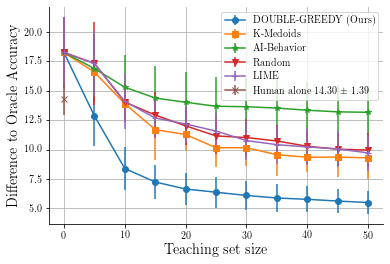

In [38]:

teaching_sizes = [i*PLOT_INTERVAL for i in range(11)]
actual_max_trials = len(scores_ours) 

avgs_rand = [np.average([ scores_oracle[triall] - scores_ours[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle[triall] - scores_ours[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
plt.errorbar(teaching_sizes,  avgs_rand, yerr=stds_rand, marker = "o",  label=f'DOUBLE-GREEDY (Ours)')


avgs_rand = [np.average([scores_oracle[triall] - scores_medoid[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([ scores_oracle[triall] -scores_medoid[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
plt.errorbar(teaching_sizes,  avgs_rand, yerr=stds_rand, marker = "s",   label=f'K-Medoids')

avgs_rand = [np.average([scores_oracle[triall]- scores_aibaseline[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle[triall] -scores_aibaseline[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
plt.errorbar(teaching_sizes,  avgs_rand,yerr=stds_rand, marker = "*",   label=f'AI-Behavior')


avgs_rand = [np.average([scores_oracle[triall] - scores_random[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle[triall] -scores_random[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
#plt.errorbar(list(range(1,len(teaching_sizes)+1)),  avgs_rand, yerr=stds_rand, label=f'random')
plt.errorbar(teaching_sizes,  avgs_rand,yerr=stds_rand, marker = "v",  label=f'Random')

avgs_rand = [np.average([scores_oracle[triall] - scores_lime[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle[triall] -scores_lime[triall][i] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
#plt.errorbar(list(range(1,len(teaching_sizes)+1)),  avgs_rand, yerr=stds_rand, label=f'random')
plt.errorbar(teaching_sizes,  avgs_rand,yerr=stds_rand, marker = "+",  label=f'LIME')

avgs_rand = [np.average([scores_oracle[triall] - scores_human[triall] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
stds_rand = [np.std([scores_oracle[triall] -scores_human[triall] for triall in range(actual_max_trials)]) for i in range(len(teaching_sizes))]
#plt.errorbar(list(range(1,len(teaching_sizes)+1)),  avgs_rand, yerr=stds_rand, label=f'random')
#plt.errorbar(teaching_sizes,  avgs_rand,yerr=stds_rand, marker = "x",  label=f'Human alone')
plt.errorbar(teaching_sizes[0],  avgs_rand[0],yerr=stds_rand[0], marker = "x",  label=f'Human alone {avgs_rand[0]:.2f} $\pm$ {stds_rand[0]:.2f}')



ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.grid()
plt.legend(fontsize='large')
plt.legend()
plt.ylabel('Difference to Oracle Accuracy',  fontsize='x-large')
plt.xlabel('Teaching set size', fontsize='x-large')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.savefig("teaching_complexity_Bgreedy_8.pdf", dpi = 1000)
plt.show()

In [ ]:
results = [scores_ours,scores_medoid,scores_random,scores_aibaseline,scores_lime,scores_human,scores_oracle]
res = pickle.dump(results,open("results_setA_4.p","wb"))

In [ ]:
stds_rand

[2.8310463938919805,
 2.8310463938919805,
 2.8310463938919805,
 2.8310463938919805,
 2.8310463938919805,
 2.8310463938919805,
 2.8310463938919805,
 2.8310463938919805,
 2.8310463938919805,
 2.8310463938919805,
 2.8310463938919805]